<!--  -->

# 1. Importing required libraries 

<!--  -->

In [1]:
from warnings import filterwarnings

filterwarnings(action='ignore')

import pandas as pd

import numpy as np

from IPython.display import clear_output

import matplotlib.pyplot as plt

import os

import shutil

from darts import TimeSeries

from darts.dataprocessing.transformers import Scaler

from darts.utils.timeseries_generation import datetime_attribute_timeseries

from darts.metrics import mape,mse

from darts.models import AutoARIMA, Prophet, RandomForest, LightGBMModel, RNNModel, BlockRNNModel

print(50*'#')

print(4*' '+"Successfully imported required libraries!!")

print(50*'#')

2022-07-19 12:27:45 prophet.plot ERROR: Importing plotly failed. Interactive plots will not work.


##################################################
    Successfully imported required libraries!!
##################################################


<!--  -->

<!--  -->

# 2. Importing observation data and verifying required specifications

<!--  -->

## 2.1 Import 

In [2]:
def import_observation_windspeed_data(file_name = 'obs_data.csv'):
    
    """
    
    Function imports observation wind speed data provided in csv file 
    
    Input: file_name (str), default: 'obs_data.csv'
    
    Output: series (pandas DataFrame object) or None object
    
    """
    try:

        # Importing series data

        series = pd.read_csv(file_name,index_col=0,parse_dates=True)

        # Sorting based on time index labels

        series.sort_index(inplace=True)

        # Printing data

        series.columns = ['windspeed',]
        
        return series
    
    except: 
                
        return None


## 2.2 Converting data to daily average

In [3]:
def compute_daily_mean(series):

    """
    
    Function computes daily mean.
    
    Input: series (pandas DataFrame object)
    
    Onput: series_daily_mean: series averaged to daily-mean(pandas DataFrame object)
    
    """
    try:
        
        series_daily_mean = series.resample(rule='D').mean()
        
        return series_daily_mean
    
    except:
        
        return None
    

## 2.3 Verifying required specifications

In [4]:
# Function definition

def verify_required_specifications(series):
    
    """
    Input: series (pandas DataFrame objects). 
    
    Output: 
            
            1. proceed: True or False (Boolean)
            
            2. error_msg: specifing condition or conditions which are mismatched(str)
    
    """

    nmissing = series.iloc[:,0].isna().sum()
    
    if nmissing == 0:
        
        # Returning boolean if requirements are verified 
        
        proceed = True
        
        error_msg = ''
        
        return proceed, error_msg
    
    else:
        
        proceed_lst = []
        
        error_msg = ''
        
        # Condition 1: Minimum of 24 months data (continuous)
        
        n_months = len(series.index.strftime("%m-%Y")) 

        if n_months < 24:
            
            proceed_lst.append(False)
            
            error_msg = error_msg + f"Condition:1 Total number of months (continuous) >= 24 (failed)\n"
            
        else:
            
            proceed_lst.append(True)

        # Condition 2: maximum of 10% missing values
        
        percentage_null = (nmissing / len(series)) * 100
        
        if percentage_null > 10:
            
            proceed_lst.append(False)
            
            error_msg = error_msg + f"Condition:1 Percentage of number of missing values < 10% (failed)\n"
            
        else:
            
            proceed_lst.append(True)
            
            
        # Condition 3: maximum of 5 days gap

        # logic: cum sum value of a non-null value repeats for the next consecutive nan values hence
        # repetition of cum sum value is observed, (value_counts)counting total repititions gives us
        # length of consecutive nan values + 1, +1 since non null value's count is also included.

        max_gap_len = (series.notnull().astype(int).cumsum().value_counts() - 1).max()        

        if max_gap_len > 5:
            
            proceed_lst.append(False)
            
            error_msg = error_msg + f"Condition:2 maximum gap <= 5 days (failed)\n"
            
        else:
            
            proceed_lst.append(True)
         
        # Condition 4: atleast 15 days of data for each month
        
        series_mon = series.dropna().resample('MS').mean()
        
        series_mon['days_count'] = series.dropna().resample('MS').count()
        
        min_day_count = (len(series_mon.loc[series_mon['days_count'] < 15,:]) > 0 )
        
        if min_day_count:

            proceed_lst.append(False)
            
            error_msg = error_msg + f"Condition:3 number of days for each month >= 15 (failed)\n"
            
        else:
            
            proceed_lst.append(True)
                 

        if all(proceed_lst):
            
            return True, ''
        
        else:
            
            return False, error_msg

## 2.4 Interpolation

In [5]:
# Function definition

def fill_missing_values_interpolation(series):
    
    """
    
    Input: series (pandas DataFrame objects). 
    
    Output: series_mod: series with missing values filled(pandas DataFrame objects)
    
    """
    
    nmissing = series.iloc[:,0].isna().sum()
    
    percentage_null = (nmissing/len(series)) * 100
    
    if nmissing == 0:
                
        return series
    
    else:

        series_mod = series.interpolate('time')

        #print(f"{nmissing} missing values found out of {len(series)} data-points, accounting for {percentage_null:3.2f} %")

        #print()

        #print("filled by interpolation")
        
        #print()
        
        return series_mod


## 2.5 Main function

In [6]:
def main_function_1_import_verify_interpolate():
    
    """
    
    Function imports wind speed data, verifies if the required specifications are satified and interpolates
    
    if found any nan values.
    
    Output: pandas DataFrame object or None
    
    """
    
    series_imported = import_observation_windspeed_data(file_name = 'obs_data.csv')
    
    if series_imported is None:
        
        print("Importing wind speed data failed, please check the observation file name and its data format")
        
        print()
        
        return None
    
    series_daily_mean = compute_daily_mean(series_imported)
    
    if series_daily_mean is None:
        
        print("Averaging wind speed data to daily mean failed, please check the frequency of the data")
        
        print()
        
        return None
    
    proceed, err_msg = verify_required_specifications(series_daily_mean)
    
    if not proceed:
        
        print(err_msg)
        
        print()
        
        return None
    
    else:
        
        series_daily_mean_filled = fill_missing_values_interpolation(series_daily_mean)
        
        return series_daily_mean_filled

<!--  -->

<!--  -->

# 3. Computing required components for forecast process

<!--  -->

## 3.1 Computing monthly-mean and climatology (Long term average)

In [8]:
def compute_monthly_mean_climatology(series):
    
    """
    
    Function computes month-mean wind speeds and monthly-mean climatology (long term average).
    
    Input: Daily-mean wind speed (pandas DataFrame object)
    
    Output: 1. monthly-mean wind speed (pandas DataFrame object)
            
            2. monthly-mean climatology (pandas DataFrame object)
    """
    
    # Monthly-mean

    series_mm = series.resample('MS').mean()

    # Climatology

    climatology = series_mm.copy()

    climatology['month'] = climatology.index.month

    climatology = climatology.groupby('month').mean()

    climatology.columns = ['climatology',]

    return series_mm, climatology
    

## 3.2 Computing components required for model training and validation

In [9]:
def compute_cmpnts_required_forcasting(series,plot_train_validation=True):
    
    """

    Function computes required components to start forecast process.
    
    Input: (pandas DataFrame object)
    
    Output:

    train_transformed - train part of target series transformed or normalized(TimeSeries object) 

    validation_transformed - Validation part of target series transformed or normalized(TimeSeries object)

    validation - Validation part of target series(TimeSeries object)

    trnsfm - Transform object

    covariates - year, month covariates (normalized) stacked together(TimeSeries object)

    show_plots - Boolean on whether to display line plots of predictions (default False)

    Output: tuple -> (error, min_error, model_code(best model))

    error: Validation error produced by 6 different models(Pandas Series object)

    
    """        
    # Converting series to timeseries object

    series_TS = TimeSeries.from_dataframe(series).astype('float32')

    # Dividing into train and validation sets

    # train: Series start to 13 th data-point from last

    # validation: last 12 months data

    train, validation = series_TS[:-12:], series_TS[-12::]

    if plot_train_validation:

        train.plot(label='train')

        validation.plot(label='validation')

        plt.xlabel('Month',fontsize=12)

        plt.ylabel('Wind speed (m/s)',fontsize=12)    

        plt.show();

    # Normalizing time series

    trnsfm =  Scaler()

    train_transformed = trnsfm.fit_transform(train)

    validation_transformed = trnsfm.transform(validation)

    full_series_transformed = trnsfm.transform(series_TS)

    # Defining covariates (month and year) and stacking them

    index = pd.date_range(series.index[0],
                          series.index[-1] + pd.Timedelta(365,'days'),
                          freq='MS')

    index_ts = TimeSeries.from_times_and_values(times=index,values=np.zeros(len(index)))

    year_covariate = datetime_attribute_timeseries(index_ts,'year')

    year_covariate = Scaler().fit_transform(year_covariate)

    month_covariate = datetime_attribute_timeseries(index_ts,'month')

    month_covariate = Scaler().fit_transform(month_covariate)

    covariates = year_covariate.stack(month_covariate).astype('float32')

    return trnsfm, validation, train_transformed, validation_transformed, full_series_transformed, covariates


## 3.3 Main function

In [10]:
def main_function_2_compute_fcst_req_cmpnts(series):
    
    """
    
    Function computes components required for starting forecast process
    
    Input: Daily-mean wind speed (pandas Series object)
    
    Output: Components required for forecasting (tuple object)
    
    """
        
    series_monthly_mean, climatology = compute_monthly_mean_climatology(series)
        
    components = compute_cmpnts_required_forcasting(series_monthly_mean)
    
    trnsfm, validation, train_transformed, validation_transformed, full_series_transformed, covariates = components
        
        
    return (series_monthly_mean, climatology,
               trnsfm, validation,
               train_transformed, validation_transformed,
               full_series_transformed, covariates)

In [11]:
# components = main_function_2_compute_fcst_req_cmpnts(series_daily_mean)

<!--  -->

# 4. Forecasting

<!--  -->

## 4.1 Forecasting with default settings and obtaining performance estimates of different models

In [12]:
def get_forecast_perf_estimates(train_transformed,validation_transformed,
                                validation,trnsfm,covariates,
                                show_plots=True):
    
    """
    Function provides performance estimates of 6 models (2 statistical, 2 ML-Regression based, 2 Sequence based)
    
    with default settings.
    
    Input: 
    
    train_transformed - train part of target series transformed or normalized(TimeSeries object) 
    
    validation_transformed - Validation part of target series transformed or normalized(TimeSeries object)
    
    validation - Validation part of target series(TimeSeries object)
    
    trnsfm - Transform object
    
    covariates - year, month covariates (normalized) stacked together(TimeSeries object)
    
    show_plots - Boolean on whether to display line plots of predictions (default False)
    
    Output: tuple -> (error, fig)
    
    error: Validation error produced by 6 different models(Pandas Series object)
    
    fig: matplotib figure object
    
    """
    
    
    # model input steps 

    i = 12

    # model output step

    o = 1
    
    # length of full series
    
    series_len = len(train_transformed) + len(validation_transformed)
    
    error = {}

    # 1. Statitical models

    ## 1.1 AutoARIMA

    try:

        pred_AA = AutoARIMA(m=12,maxiter=100).fit(train_transformed,future_covariates=covariates).predict(n=12,future_covariates=covariates)

    except:

        pred_AA = AutoARIMA(maxiter=100).fit(train_transformed,future_covariates=covariates).predict(n=12,future_covariates=covariates)


    pred_AA = trnsfm.inverse_transform(pred_AA)

    clear_output()

    error['AA'] = mape(validation,pred_AA)

    ## 1.2 Prophet

    pred_PH = Prophet().fit(train_transformed,future_covariates=covariates).predict(n=12,future_covariates=covariates)

    pred_PH = trnsfm.inverse_transform(pred_PH)

    clear_output()

    error['PH'] = mape(validation,pred_PH)

    # 2. Regression models

    ## 2.1 RandomForest

    try:

        pred_RF = RandomForest(lags=i,lags_future_covariates=[0,],lags_past_covariates=[-6,-5,-4,-3,-2,-1,]) \
    .fit(train_transformed,future_covariates=covariates,past_covariates=covariates) \
    .predict(n=12,future_covariates=covariates)
        
    except:

        pred_RF = RandomForest(lags=6,lags_future_covariates=[0,],lags_past_covariates=[-6,-5,-4,-3,-2,-1,]) \
    .fit(train_transformed,future_covariates=covariates,past_covariates=covariates) \
    .predict(n=12,future_covariates=covariates)

    pred_RF = trnsfm.inverse_transform(pred_RF)

    error['RF'] = mape(validation,pred_RF)

    ## 2.2 LightGBMModel
    try:

        pred_LG = LightGBMModel(lags=i,lags_future_covariates=[0,],lags_past_covariates=[-6,-5,-4,-3,-2,-1,],
                               min_data_in_bin=1,min_data_in_leaf=1,) \
        .fit(train_transformed,future_covariates=covariates,past_covariates=covariates) \
        .predict(n=12,future_covariates=covariates)

    except:

        pred_LG = LightGBMModel(lags=6,lags_future_covariates=[0,],lags_past_covariates=[-6,-5,-4,-3,-2,-1,],
                               min_data_in_bin=1,min_data_in_leaf=1,) \
        .fit(train_transformed,future_covariates=covariates,past_covariates=covariates) \
        .predict(n=12,future_covariates=covariates)

    pred_LG = trnsfm.inverse_transform(pred_LG)

    clear_output()

    error['LG'] = mape(validation,pred_LG)

    # 3. Sequence models

    # Sequence models are fitted if length of time series (train + validation) is atleast 4 years

    if series_len >= 48:

        ## 3.1 RNNModel (GRU)

        model_RNN = RNNModel(       
            model="GRU",
            input_chunk_length=i,
            output_chunk_length=1,
            hidden_dim=3,
            n_rnn_layers=1,
            n_epochs=100,
            model_name="model_RNN",
            save_checkpoints=True,force_reset=True,
            )

        model_RNN.fit(train_transformed,future_covariates=covariates)

        pred_RNN = trnsfm.inverse_transform(model_RNN.predict(n=12,future_covariates=covariates))

        clear_output()

        error['RNN'] = mape(validation,pred_RNN)

        ## 3.2 BlockRNNModel (GRU)

        model_BRNN = BlockRNNModel(
            model="GRU",
            input_chunk_length=i,
            output_chunk_length=1,
            hidden_size=3,
            n_rnn_layers=1,
            n_epochs=100,
            model_name="model_BRNN",force_reset=True,
            save_checkpoints=True)

        model_BRNN.fit(train_transformed,past_covariates=covariates)

        pred_BRNN = trnsfm.inverse_transform(model_BRNN.predict(n=12,past_covariates=covariates))

        clear_output()

        error['BRNN'] = mape(validation,pred_BRNN)
        
        shutil.rmtree('darts_logs/')

    error = pd.Series(error)

    if show_plots:

        if series_len >= 48:

            # Plotting

            fig, axes = plt.subplots(3,2,figsize=(20,24),sharey='row',sharex='col')

            ax1,ax2,ax3,ax4,ax5,ax6 = axes.flat

            # 1. Statistical models
            validation.plot(ax=ax1,label='actual')
            pred_AA.plot(ax=ax1,label='prediction')
            ax1.legend(fontsize=24)
            ax1.set_title(f'AutoARIMA (MAPE:{error["AA"]:3.2f})',fontsize=30)

            validation.plot(ax=ax2,label='actual')    
            pred_PH.plot(ax=ax2,label='prediction')
            ax2.legend(fontsize=24)
            ax2.set_title(f'Prophet(MAPE:{error["PH"]:3.2f})',fontsize=30)

            # 2. Regression models
            validation.plot(ax=ax3,label='actual')
            pred_RF.plot(ax=ax3,label='prediction')
            ax3.legend(fontsize=24)
            ax3.set_title(f'RandomForest (MAPE:{error["RF"]:3.2f})',fontsize=30)

            validation.plot(ax=ax4,label='actual')    
            pred_LG.plot(ax=ax4,label='prediction')
            ax4.legend(fontsize=24)
            ax4.set_title(f'LGBDT (MAPE:{error["LG"]:3.2f})',fontsize=30)

            # 3. Sequence models
            validation.plot(ax=ax5,label='actual')
            pred_RNN.plot(ax=ax5,label='prediction')
            ax5.legend(fontsize=24)
            ax5.set_title(f'RNN (MAPE:{error["RNN"]:3.2f})',fontsize=30)

            validation.plot(ax=ax6,label='actual')    
            pred_BRNN.plot(ax=ax6,label='prediction')
            ax6.legend(fontsize=24)
            ax6.set_title(f'BlockRNN (MAPE:{error["BRNN"]:3.2f})',fontsize=30)
            
            ax1.set_xlabel('')
            ax2.set_xlabel('')
            
            ax3.set_xlabel('')
            ax4.set_xlabel('')

            ax5.set_xlabel('Month',fontsize=24)
            ax6.set_xlabel('Month',fontsize=24)
                        
            ax1.set_ylabel('Wind speed (m/s)',fontsize=24)
            ax3.set_ylabel('Wind speed (m/s)',fontsize=24)
            ax5.set_ylabel('Wind speed (m/s)',fontsize=24)
            
            ax1.tick_params(labelsize=20)
            ax2.tick_params(labelsize=20)
            ax3.tick_params(labelsize=20)
            ax4.tick_params(labelsize=20)
            ax5.tick_params(labelsize=20)
            ax6.tick_params(labelsize=20)
            
        else:

            # Plotting

            fig, axes = plt.subplots(2,2,figsize=(20,16),sharey='row',sharex='col')

            ax1,ax2,ax3,ax4 = axes.flat

            # 1. Statistical models
            validation.plot(ax=ax1,label='actual')
            pred_AA.plot(ax=ax1,label='prediction')
            ax1.legend(fontsize=24)
            ax1.set_title(f'AutoARIMA (MAPE:{error["AA"]:3.2f})',fontsize=30)

            validation.plot(ax=ax2,label='actual')    
            pred_PH.plot(ax=ax2,label='prediction')
            ax2.legend(fontsize=24)
            ax2.set_title(f'Prophet(MAPE:{error["PH"]:3.2f})',fontsize=30)

            # 2. Regression models
            validation.plot(ax=ax3,label='actual')
            pred_RF.plot(ax=ax3,label='prediction')
            ax3.legend(fontsize=24)
            ax3.set_title(f'RandomForest (MAPE:{error["RF"]:3.2f})',fontsize=30)

            validation.plot(ax=ax4,label='actual')    
            pred_LG.plot(ax=ax4,label='prediction')
            ax4.legend(fontsize=24)
            ax4.set_title(f'LGBDT (MAPE:{error["LG"]:3.2f})',fontsize=30)
            
            ax1.set_xlabel('')
            ax2.set_xlabel('')
            
            ax3.set_xlabel('Month',fontsize=24)
            ax4.set_xlabel('Month',fontsize=24)
                        
            ax1.set_ylabel('Wind speed (m/s)',fontsize=24)
            ax3.set_ylabel('Wind speed (m/s)',fontsize=24)
            
            ax1.tick_params(labelsize=20)
            ax2.tick_params(labelsize=20)
            ax3.tick_params(labelsize=20)
            ax4.tick_params(labelsize=20)
            
        return error, fig
    
    else:
    
        return error, None
        

## 4.2 Printing the performance estimates of different models and identifying the best one

In [13]:
# Defining code name of models

def print_perf_esimates_return_best_model(error):

    model_names = {}

    model_names['AA'] = 'AutoARIMA'

    model_names['PH'] = 'Prophet'

    model_names['RF'] = 'RandomForest'

    model_names['LG'] = 'LightGBMModel'

    model_names['RNN'] = 'RNN (GRU)'

    model_names['BRNN'] = 'BRNN (GRU)'
    
    best_model_code = error.idxmin()

    error.index = error.index.map(lambda x: model_names[x])

    # Printing different models performance estimates with default settings

    print("Forecast errors (MAPE) of different models!!")

    print()

    print(error.sort_values())

    print()

    print(f"Best model is {model_names[best_model_code]} with MAPE of : {error.min():3.2f}")

    print()

    return model_names[best_model_code]


## 4.3 Hyper-parameter tuning

In [14]:
def max_n_iter(param_grid):
    
    max_count =1
    
    for val in param_grid.values():

        max_count = max_count * len(val)
        
    return max_count

def hyp_tuning_forecast(bst_mdl_code,train_transformed,
                        validation_transformed,full_series_transformed,
                        trnsfm,covariates,n_jobs,n_iter_RF,
                       n_iter_LG, n_iter_PH,n_iter_RNN,n_iter_BRNN):
    
    """
    
    Function performs hyper-parameter tuning for the model indicated through model code
    
    Input: 
    
    mdl_code: Model code(Str)
        
    train_transformed - train part of target series transformed or normalized(TimeSeries object) 
    
    validation_transformed - Validation part of target series transformed or normalized(TimeSeries object)
    
    validation - Validation part of target series(TimeSeries object)
    
    full_series_transformed - target series transformed or normalized(TimeSeries object)
    
    trnsfm - Transform object
    
    covariates - year, month covariates (normalized) stacked together(TimeSeries object)
    
    n_jobs: number of cores to use (int)
    
    Output: 
    
    forecast - 12 time steps ahead forecast (TimeSeries object)
        
    """
    print()
    
    
    if bst_mdl_code == 'RF':
                
        if len(full_series_transformed) >= 48:
            
            
            param_grid = dict(lags=[int(x) for x in np.arange(6,25,1)],
                      lags_future_covariates=[[0,]],
                      lags_past_covariates=[[-6,-5,-4,-3,-2,-1,],],
                      n_estimators=[int(x) for x in np.arange(20,151,10)],
                      max_samples=[float(x) for x in np.round(np.arange(0.2,0.91,0.1),2)])
            
            max_iter = max_n_iter(param_grid)
            
            
            best_model,best_hyp_params,val_err = RandomForest.gridsearch(parameters=param_grid,
                                                                      series=train_transformed.astype('float32'),
                                                                      future_covariates=covariates.astype('float32'),
                                                                      past_covariates=covariates.astype('float32'),
                                                                      val_series=validation_transformed.astype('float32'),
                                                                      metric=mse,n_jobs=n_jobs,
                                                                      n_random_samples=n_iter_RF,
                                                                      verbose=2)

            # Getting forecast

            best_model.fit(full_series_transformed,future_covariates=covariates,past_covariates=covariates)
        
            
        else:
            
            param_grid = dict(lags=[int(x) for x in np.arange(3,10,1)],
                      lags_future_covariates=[[0,]],
                      lags_past_covariates=[[-6,-5,-4,-3,-2,-1,],],
                      n_estimators=[int(x) for x in np.arange(20,61,5)],
                      max_samples=[float(x) for x in np.round(np.arange(0.2,0.91,0.1),2)])
            
            max_iter = max_n_iter(param_grid)
            
            
            best_model,best_hyp_params,val_err = RandomForest.gridsearch(parameters=param_grid,
                                                                      series=train_transformed.astype('float32'),
                                                                      future_covariates=covariates.astype('float32'),
                                                                      past_covariates=covariates.astype('float32'),
                                                                      val_series=validation_transformed.astype('float32'),
                                                                      metric=mse,n_jobs=n_jobs,
                                                                      n_random_samples=n_iter_RF,
                                                                      verbose=2)

            # Getting forecast

            best_model.fit(full_series_transformed,future_covariates=covariates,past_covariates=covariates)
        

        forecast = best_model.predict(n=12,future_covariates=covariates,past_covariates=covariates)
        
        clear_output()
        
        #print(best_hyp_params)
        
        #print(f"Best performing model: RandomForest")

    elif bst_mdl_code == 'LG':
        
        if len(full_series_transformed) >= 48:
            
            
            param_grid = {'lags':[int(x) for x in np.arange(6,25,1)],
                          'lags_future_covariates':[[0,]],
                          'lags_past_covariates':[[-6,-5,-4,-3,-2,-1,],],
                          'learning_rate':[0.01,0.04,0.08,0.2,0.5,0.6],
                          'max_depth':[int(x) for x in np.arange(2,10,1)],
                          'n_estimators':[int(x) for x in np.arange(20,200,10)],
                          'subsample':[float(np.round(x,2)) for x in np.arange(0.2,0.91,0.2)],
                          'colsample_bytree':[float(np.round(x,2)) for x in np.arange(0.2,0.91,0.2)],
                          'reg_lambda':[0.3,0.5,0.8,1],'objective':['regression',],'num_leaves':[35,]}
            
            max_iter = max_n_iter(param_grid)
            
            
            best_model,best_hyp_params,val_err = LightGBMModel.gridsearch(parameters=param_grid,
                                                                      series=train_transformed,
                                                                      future_covariates=covariates,
                                                                      past_covariates=covariates,
                                                                      val_series=validation_transformed,
                                                                      metric=mse,n_jobs=n_jobs,
                                                                          n_random_samples=n_iter_LG,
                                                                         verbose=2)

            # Getting forecast

            best_model.fit(full_series_transformed,future_covariates=covariates,past_covariates=covariates)
        
        else:
            
            param_grid = {'lags':[int(x) for x in np.arange(3,10,1)],
                          'lags_future_covariates':[[0,]],
                          'lags_past_covariates':[[-6,-5,-4,-3,-2,-1,],],
                          'learning_rate':[0.01,0.04,0.08,0.2,0.5,0.6],
                          'max_depth':[int(x) for x in np.arange(2,5,1)],
                          'n_estimators':[int(x) for x in np.arange(20,91,10)],
                          'subsample':[float(np.round(x,2)) for x in np.arange(0.2,0.91,0.2)],
                          'colsample_bytree':[float(np.round(x,2)) for x in np.arange(0.2,0.91,0.2)],
                          'reg_lambda':[0.3,0.5,0.8,1],'objective':['regression',],'num_leaves':[16,]}
            
            max_iter = max_n_iter(param_grid)
            
            
            best_model,best_hyp_params,val_err = LightGBMModel.gridsearch(parameters=param_grid,
                                                                      series=train_transformed,
                                                                      future_covariates=covariates,
                                                                      past_covariates=covariates,
                                                                      val_series=validation_transformed,
                                                                      metric=mse,n_jobs=n_jobs,
                                                                          n_random_samples=n_iter_LG,
                                                                         verbose=2)

            # Getting forecast

            best_model.fit(full_series_transformed,future_covariates=covariates,past_covariates=covariates)
        

        forecast = best_model.predict(n=12,future_covariates=covariates,past_covariates=covariates)
        
        clear_output()
        
        #print(best_hyp_params)
        
        #print(f"Best performing model: LightGBMModel")

    elif bst_mdl_code == 'PH':
        
        
        param_grid = {
            'changepoint_prior_scale': [0.001, 0.003,0.01,0.03, 0.1,0.3, 0.9],
            'seasonality_prior_scale': [0.01, 0.03, 0.1, 0.3, 1.0, 3, 10],
            'seasonality_mode': ['additive','multiplicative'],
            'changepoint_range': np.round(np.arange(0.8,0.96,0.05),2)}
        
        max_iter = max_n_iter(param_grid)
        
        
        best_model,best_hyp_params,val_err = Prophet.gridsearch(parameters=param_grid,
                                                                  series=train_transformed,
                                                                  future_covariates=covariates,
                                                                  val_series=validation_transformed,
                                                                  metric=mse,n_jobs=n_jobs,
                                                                n_random_samples=n_iter_PH,
                                                               verbose=2)
        
        # Getting forecast
                
        best_model.fit(full_series_transformed,future_covariates=covariates)
        
        forecast = best_model.predict(n=12,future_covariates=covariates)
        
        clear_output()
        
        #print(best_hyp_params)
        
        #print(f"Best performing model: Prophet")
    
    elif bst_mdl_code == 'AA':
        
        # AutoARIMA model automatically performs hyp-tuning
        # under the hood with ARIMA model hence no hyp-tuning for this model
        
        # Getting validation error
        
        try:
                        
            best_model = AutoARIMA(m=12,maxiter=100)
        
            best_model.fit(full_series_transformed,future_covariates=covariates)
        
            forecast = best_model.predict(n=12,future_covariates=covariates)

        
        except:
            
                        
            best_model = AutoARIMA(maxiter=100)
        
            best_model.fit(full_series_transformed,future_covariates=covariates)
        
            forecast = best_model.predict(n=12,future_covariates=covariates)

        clear_output()
        
        #print(f"Best performing model: AutoARIMA" )
    
    # NOTE: Distribution of hyper-parameter tuning process is not working for RNN, BRNN models
    #       hence just using one cpu.
    
    elif bst_mdl_code == 'RNN':

        param_grid = {'model':["GRU",],
              'input_chunk_length':[int(x) for x in np.arange(6,25,1)],
              'n_rnn_layers':[int(x) for x in np.arange(1,4,1)],
              'hidden_dim':[int(x) for x in np.arange(1,6,1)],
              'n_epochs':[100,],
              }


        max_iter = max_n_iter(param_grid)
            
        
        best_model,best_hyp_params,val_err = RNNModel.gridsearch(parameters=param_grid,
                                                                  series=train_transformed,
                                                                  val_series=validation_transformed,
                                                                  future_covariates=covariates,
                                                                  metric=mse,n_jobs=1,
                                                                 n_random_samples=n_iter_RNN,
                                                                verbose=2)
        


        best_model.force_reset = True

        # Getting forecast

        best_model.fit(full_series_transformed,future_covariates=covariates)

        forecast = best_model.predict(n=12,future_covariates=covariates)

        clear_output()

        #print(best_hyp_params)

        #print(f"Best performing model: RNN (GRU)")


    elif bst_mdl_code == 'BRNN':
        
        param_grid = {'model':["GRU",],
              'input_chunk_length':[int(x) for x in np.arange(6,25,1)],
              'output_chunk_length':[1,],
              'n_rnn_layers':[int(x) for x in np.arange(1,4,1)],
              'hidden_size':[int(x) for x in np.arange(1,6,1)],
              'n_epochs':[100,],
              }

        max_iter = max_n_iter(param_grid)
            
        best_model,best_hyp_params,val_err = BlockRNNModel.gridsearch(parameters=param_grid,
                                                                  series=train_transformed,
                                                                  val_series=validation_transformed,
                                                                  past_covariates=covariates,
                                                                  metric=mse,n_jobs=1,
                                                                      n_random_samples=n_iter_BRNN,
                                                                     verbose=2)

        best_model.force_reset = True

        # Getting forecast

        best_model.fit(full_series_transformed,past_covariates=covariates)

        forecast = best_model.predict(n=12,past_covariates=covariates)

        clear_output()

        #print(best_hyp_params)

        #print(f"Best performing model: BlockRNN (GRU)")

    
    else:
        
        print("Provided model code is invalid!!")
        
    
    return trnsfm.inverse_transform(forecast)

## 4.4 Main function

In [15]:
def main_function_3_FcstDefault_HypTuning(components,n_jobs,n_iter_RF,
                       n_iter_LG, n_iter_PH,n_iter_RNN,n_iter_BRNN,show_plots):
    
    """
    
    Function performs three tasks
    
    1. 
    
    Input: Forecast components produced by main_function_2.. (tuple)
    
    n_jobs: number of cpus to use (int)
    
    n_iter_RF: number of iteration of random foreast model (int)
    
    n_iter_LG: number of iterations for LightGBMModel model (int)
    
    n_iter_PH: number of iteration of Prophet model (int)
    
    n_iter_RNN: number of iteration of RNN model (int)
    
    n_iter_BRNN: number of iteration of BRNN model (int)
    
    show_plots: default (Boolean)
    
    Output: 

    forecast - (TimeSeries object) 
    climatology - (pandas DataFrame object) 
    trsfm - (darts Scaler transform object) 
    full_series - (TimeSeries object) 
    
    """
    
    (series_monthly_mean, climatology, trnsfm, validation,train_transformed, validation_transformed, full_series_transformed, covariates) = components
    
    
    error, fig = get_forecast_perf_estimates(train_transformed,validation_transformed,
                                validation,trnsfm,covariates,
                                show_plots=True)
    
    clear_output()
    
    error = error.sort_values()
    
    best_model_code = error.index[0]
    
    best_error = error.values[0]
    
    next_best_model_code = error.index[1] 
    
    next_best_error = error.values[1]
    
    if (best_model_code == 'LG') and (np.abs(best_error-next_best_error) <= 2):
            
        best_model_code = next_best_model_code
        
        going_with_next_best = True
        
    else:
        
        going_with_next_best = False
        
        
    forecast = hyp_tuning_forecast(best_model_code,train_transformed,
                        validation_transformed,full_series_transformed,
                        trnsfm,covariates,n_jobs,n_iter_RF,
                       n_iter_LG, n_iter_PH,n_iter_RNN,n_iter_BRNN)
    
    
    best_model_name = print_perf_esimates_return_best_model(error)     
    
    if going_with_next_best:
        
        print('Hyper-parametering tuning for RandomForest model and obtaining forecast')
        
        print()
        
        print("From error (MAPE) values, LightGBMModel is observed to be best but with < 5% difference from the next best model")
        
        print()
        
        print('LightGBMModel is observed to produce constant value forecasts when provided data is < 5 years, which is not desirable.', end=' ')
        
        print('Hence forecast is produced with next best model')
        
        print()
    
    else:

        print(f'Hyper-parametering tuning for {best_model_name} model and obtaining forecast')
        
        print()
    

    print("Plots of different model forecasts in the validation period with performance estimates")
    
    print()
    
    if fig is not None:
        
        fig
        
    full_series = trnsfm.inverse_transform(full_series_transformed)
    
    return forecast, climatology, full_series


<!--  -->

# 5. Computing forecast deviation from climatology, plotting results and saving

<!--  -->

## 5.1 Modifying forecast to readable format and calculating its deviation from climatology

In [17]:
def compute_forecast_results(forecast, climatology):
    
    """
    Function changes the format of forecast provided to simple tabular format, adds climatology
    
    values for the corresponding months and also computes forecast deviation from the climatology in percentage(%)
    
    Input:
    
    foreacast: forecast values (TimeSeries object)
    
    climatology: climatology (pd.DataFrame object)
    
    Output:
    
    result (pd.DataFrame object)
    
    """
    forecast_df = forecast.pd_dataframe()

    forecast_df.columns = ['forecast']

    forecast_df = forecast_df.reset_index()

    forecast_df.index = forecast_df['DATE'].dt.month

    forecast_df.index.name = 'month'

    result = pd.merge(forecast_df, climatology,on='month')

    result.set_index('DATE',inplace=True)

    result.index.name = 'month'

    result['deviation in %'] = ((result['forecast'] - result['climatology'])/result['climatology']) * 100
    
    result.loc[result['forecast'] < 0,'forecast'] = 0
    
    return result

        

## 5.2 Ploting forecast and climatology

In [18]:
def plot_result(result,full_series,save_fig=True):
    
    """
    Plots the results provided.
    
    Input:
    
    result: output of compute_forecast_results function (pandas DataFrame object)
    
    full_series: (Timeseries object)
    
    """
    
    forecast = TimeSeries.from_series(result['forecast'])

    climatology = TimeSeries.from_series(result['climatology'])
    
    fig,ax = plt.subplots(1,1,figsize=(20,16))
    
    full_series.plot(label='Time series',color='k',lw=5)
    
    forecast.plot(label='Forecast',color='b',lw=5)

    climatology.plot(label='Climatology',color='g',lw=5)
    
    ax.axvline(x=result.index[0],color='grey',ls='--',lw=5)
    
    ax.tick_params(size=10,labelsize=20)
    
    ax.legend(fontsize=24)

    ax.set_xlabel('Month',fontsize=24)
    
    ax.set_ylabel('Wind speed (m/s)',fontsize=24)
    
    if save_fig:
        
        plt.savefig("Forecast_plot.png",dpi=300,facecolor='w')


## 5.3 Main function

In [19]:
def main_function_4_ploting_fcst_clim_save_data(forecast, climatology, full_series, save_figure=True):
    
    """
    Function provides forecast deviation from climatology, plots and saves the data in csv file format
    
    Input:
        
    foreacast: forecast values (TimeSeries object)
    
    climatology: climatology (pd.DataFrame object)

    full_series: (Timeseries object)
    
    """

    # Computing forecast results, climatology and forecast deviation from climatology 

    results = compute_forecast_results(forecast, climatology)

    # Plotting forecast results, by default save_fig is set to False in order to save it, change it to True 

    plot_result(result=results, full_series=full_series,save_fig=save_figure)

    # Changing index format

    results.index = results.index.strftime('%b-%Y')
    
    # Printing results
    
    print(results)
    
    # Saving results in csv file format
    
    results.to_csv('Forecast_results.csv')

# 6. Execution 

In [20]:
print(f'Total cpus in the system are:{os.cpu_count() // 2}')

Total cpus in the system are:8


## Parameters which can be modified (advanced users)

In [21]:
# Number of cpus to use for distributing the computation load 

# Default set to 1 but can be set to upto total number of cpus as mentioned by output message of above cell

n_jobs = 8

# Number of parameter combinations to tune the forecasting model

# In simple terms higher the number provided better could be the model fit.

# Recommended range is next to default value in commented part

# NOTE: Higher the number of n_iter, doesn't guarantee to give output.
# Also increasing n_iter increases computation time 

n_iter_RF = 200 # (1-500) 

n_iter_LG = 800 # (1-2000)

n_iter_PH = 100  # (1-392)

n_iter_RNN = 50 # (1-285)

n_iter_BRNN = 50# (1-285)


<!--  -->

In [22]:
# Section 1: Importing required libraries (already done)

In [23]:
# Section 2: Importing observation data and verifying required specifications

series_daily_mean = main_function_1_import_verify_interpolate()

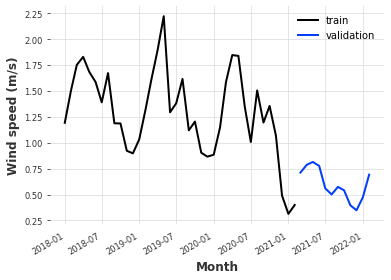

In [24]:
# Section 3: Computing required components for forecast process

try:
    
    components = main_function_2_compute_fcst_req_cmpnts(series_daily_mean)
    
except AttributeError:
    
    print("Above section is not excecuted or an error occured in its execution")
    

Forecast errors (MAPE) of different models!!

LightGBMModel    50.036578
AutoARIMA        63.917100
Prophet          69.775101
BRNN (GRU)       79.636663
RNN (GRU)        80.009913
RandomForest     82.021199
dtype: float64

Best model is LightGBMModel with MAPE of : 50.04

Hyper-parametering tuning for LightGBMModel model and obtaining forecast

Plots of different model forecasts in the validation period with performance estimates



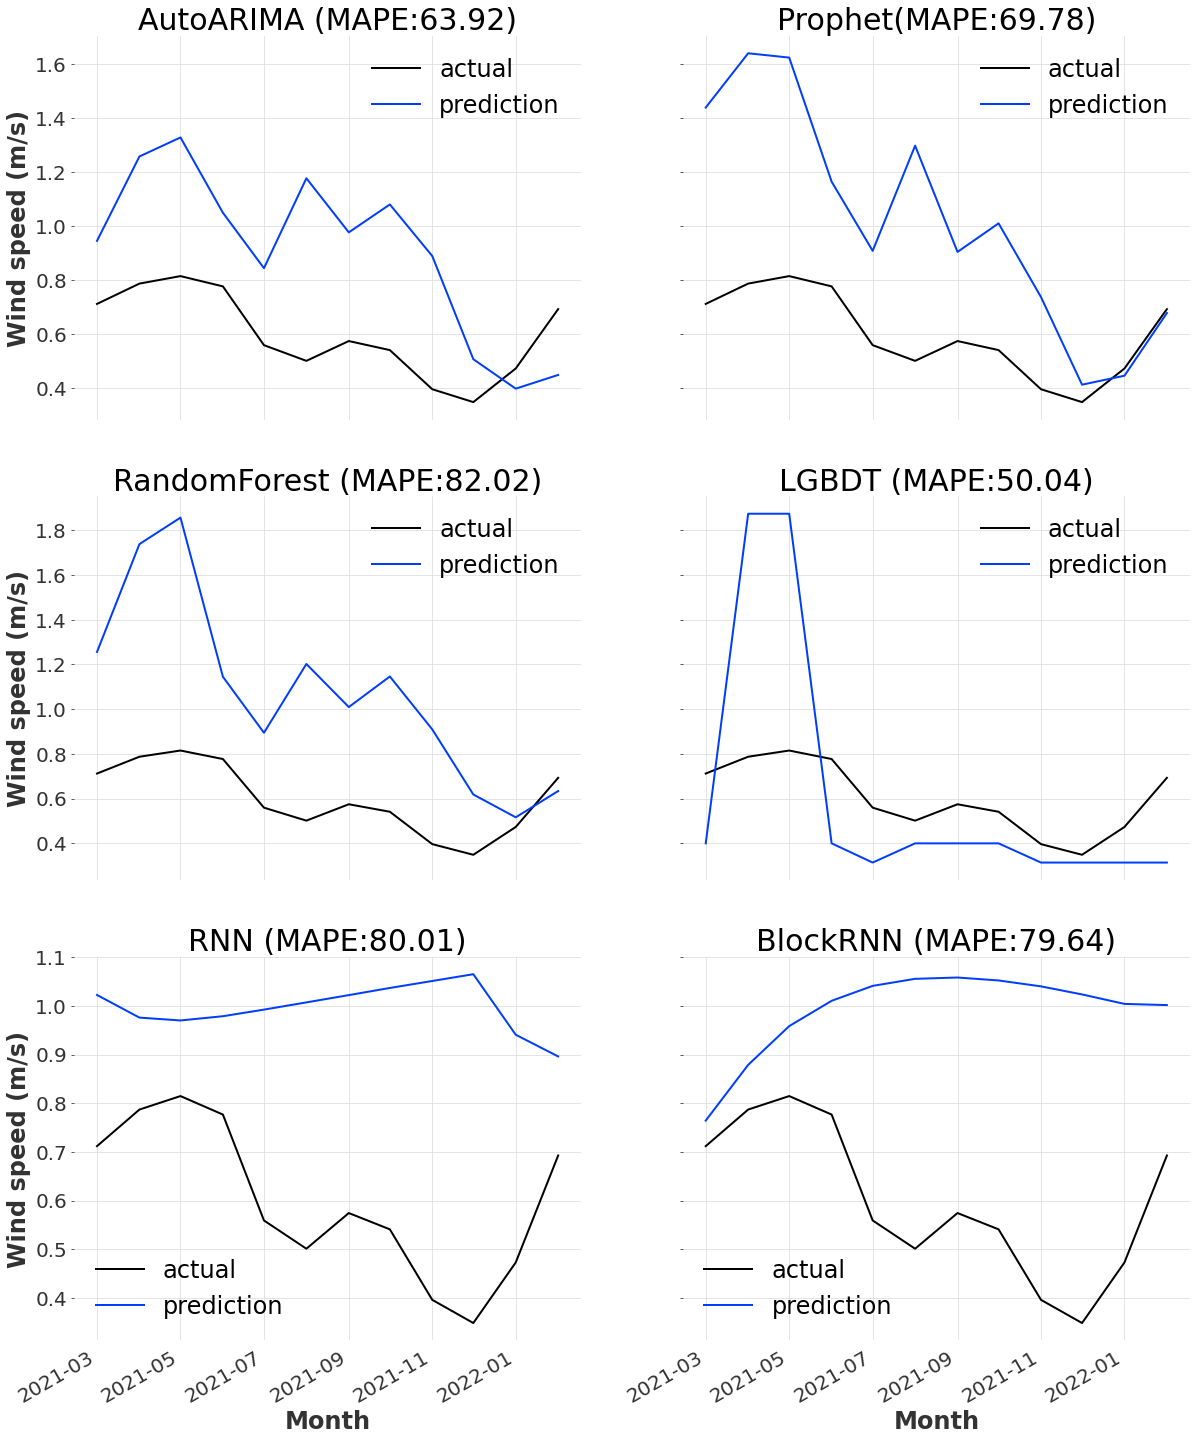

In [25]:
# Section 4: Forecasting

try:

    forecast, climatology, full_series = main_function_3_FcstDefault_HypTuning(components,n_jobs,n_iter_RF,
                           n_iter_LG, n_iter_PH,n_iter_RNN,n_iter_BRNN,show_plots=True)
    
except NameError:
    
    print("Above section is not excecuted or an error occured in its execution")

          forecast  climatology  deviation in %
month                                          
Mar-2022  0.890546     1.413891      -37.014516
Apr-2022  0.890546     1.589632      -43.977835
May-2022  0.890546     1.639998      -45.698323
Jun-2022  0.890546     1.252242      -28.883879
Jul-2022  0.890546     1.084481      -17.882736
Aug-2022  0.890546     1.323864      -32.731266
Sep-2022  0.890546     1.019457      -12.645000
Oct-2022  0.890546     1.072035      -16.929362
Nov-2022  0.890546     0.822682        8.249187
Dec-2022  0.890546     0.650523       36.897021
Jan-2023  0.890546     0.779632       14.226548
Feb-2023  0.890546     1.014627      -12.229177


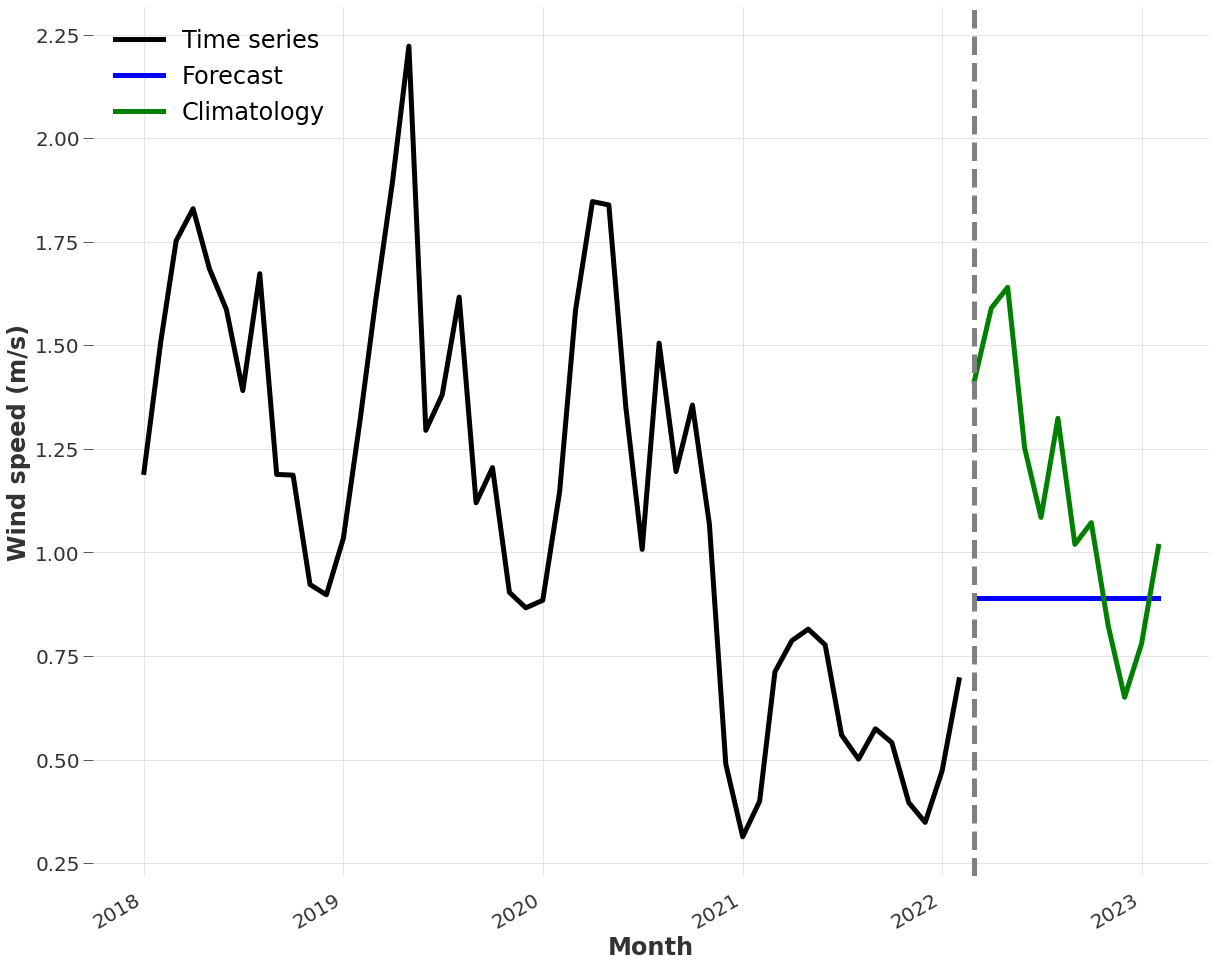

In [26]:
# Section 5: Computing forecast deviation from climatology, plotting results and saving

try:
    
    main_function_4_ploting_fcst_clim_save_data(forecast, climatology, full_series, save_figure=True)
    
except NameError:
    
    print("Above section is not excecuted or an error occured in its execution")
    

<!--  -->